A mixture of $N =10$ random Gaussians centered in $[-1,1]^n$ 
$$
f_{\mu,\sigma}(x, y) = \sum_{i=1}^{N} \frac{1}{\sigma_i\sqrt{2\pi}}\exp\left(-\frac{(x-\mu_i)^2}{2\sigma_i^2}\right)
$$
 is defined over the square $[-1, 1]^2$

In [4]:
using Globtim
include("../src/lib_func.jl") # Include the library of functions

# Constants and Parameters
d = 8 # Initial Degree 
const n, a, b = 2, 1, 1 
const scale_factor = a / b       # Scaling factor appears in `main_computation`, maybe it should be a parameter.
const delta, alpha = .9 , 8 / 10  # Sampling parameters
const tol_l2 = 5e-4             # Define the tolerance for the L2-norm

N = 10
params = init_gaussian_params(N, .2)
# Create a closure that captures params
rand_gaussian_closure = (x) -> rand_gaussian(x, params)
f = rand_gaussian_closure; # Function to be optimized


In [5]:
while true # Potential infinite loop
    global poly_approx = MainGenerate(f, 2, d, delta, alpha, scale_factor, 0.2) # computes the approximant in Chebyshev basis
    if poly_approx.nrm < tol_l2
        println("attained the desired L2-norm: ", poly_approx.nrm)
        break
    else
        println("current L2-norm: ", poly_approx.nrm)
        println("Number of samples: ", poly_approx.N)
        global d += 1
    end
end;

current L2-norm: 0.009243968577420247
Number of samples: 17
current L2-norm: 0.0055473897945479056
Number of samples: 21
current L2-norm: 0.00412463072049382
Number of samples: 24
current L2-norm: 0.002685093750888892
Number of samples: 28
current L2-norm: 0.002270794222583017
Number of samples: 31
current L2-norm: 0.0016628964824793606
Number of samples: 35
current L2-norm: 0.001191953881303839
Number of samples: 39
current L2-norm: 0.0008498185316856838
Number of samples: 44
current L2-norm: 0.0006347217877473163
Number of samples: 48
attained the desired L2-norm: 0.0004894159988403167


Define the local file names.

In [6]:
# Assuming x is already defined as @polyvar x[1:2]
loc = "inputs.ms"
# File path of the output file
file_path_output = "outputs.ms";

Build the system of partial derivatives of the approximant, output local files for MSolve.

In [7]:
using DynamicPolynomials
ap = main_nd(n, d, poly_approx.coeffs)
@polyvar(x[1:n]) # Define polynomial ring 
# Expand the polynomial approximant to the standard monomial basis in the Lexicographic order w.r.t x
names = [x[i].name for i in 1:length(x)]
open(loc, "w") do file
    println(file, join(names, ", "))
    println(file, 0)
end
# Define the polynomial approximant 
PolynomialApproximant = sum(ap .* MonomialVector(x, 0:d))
for i in 1:n
    partial = differentiate(PolynomialApproximant, x[i])
    partial_str = replace(string(partial), "//" => "/")
    open(loc, "a") do file
        if i < n
            println(file, string(partial_str, ","))
        else
            println(file, partial_str)
        end
    end
end

Solve the system using Msolve

In [8]:
run(`msolve -v 1 -f inputs.ms -o outputs.ms`)


--------------- INPUT DATA ---------------
#variables                       2
#equations                       2
#invalid equations               0
field characteristic             0
homogeneous input?               0
signature-based computation      0
monomial order                 DRL
basis hash table resetting     OFF
linear algebra option            2
initial hash table size     131072 (2^17)
max pair selection             ALL
reduce gb                        1
#threads                         1
info level                       1
generate pbm files               0
------------------------------------------
Dimension of quotient: 256
[256, 16], Non trivial / Trivial = 6.25%
Density of non-trivial part 86.33%
Time spent to generate sequence (elapsed): 0.00 sec (0.60 Gops/sec)
Time spent to compute eliminating polynomial (elapsed): 0.03 sec
Elimination polynomial has degree 256.

Starts multi-modular computations
{2}{4}{8}{16}{32}{64}{128}[0][1]
142 primes used
Time for CRT + rationa


---------------- TIMINGS ---------------
overall(elapsed)        0.00 sec
overall(cpu)            0.00 sec
select                  0.00 sec  12.8%
symbolic prep.          0.00 sec  34.5%
update                  0.00 sec   7.2%
convert                 0.00 sec  20.2%
linear algebra          0.00 sec  13.8%
reduce gb               0.00 sec   0.0%
-----------------------------------------

---------- COMPUTATIONAL DATA -----------
size of basis                    17
#terms in basis                3704
#pairs reduced                   17
#GM criterion                   136
#redundant elements               1
#rows reduced                    51
#zero reductions                  1
max. matrix data                 35 x 290 (76.562%)
max. symbolic hash table size  2^11
max. basis hash table size     2^16
-----------------------------------------



<476>Elapsed time (real root extraction) = 1.68
------------------------------------------------------------------------------------
msolve overall time           4.21 sec (elapsed) /  4.17 sec (cpu)
------------------------------------------------------------------------------------


Process(`msolve -v 1 -f inputs.ms -o outputs.ms`, ProcessExited(0))

Process the outputs, break them down.

In [12]:
using DataFrames

function average(X::Vector{Int})::Float64
    return sum(X) / length(X)
end

# Process the file and get the points
evaled = process_output_file(file_path_output)

# Parse the points into correct format
real_pts = []
for pts in evaled
    if typeof(pts)== Vector{Vector{Vector{BigInt}}}
        X = parse_point(pts)
    else 
        X = average.(pts) 
    end
    push!(real_pts, Float64.(X))
end

condition(point) = -1 < point[1] < 1 && -1 < point[2] < 1
filtered_points = filter(condition, real_pts) # Filter points using the filter function
# Colllect the critical points of the approximant 
h_x = Float64[point[1] for point in filtered_points] # Initialize the x vector for critical points of approximant
h_y = Float64[point[2] for point in filtered_points] # Initialize the y vector
h_z = map(p -> f([p[1], p[2]]), zip(scale_factor * h_x, scale_factor * h_y))
df = DataFrame(x=scale_factor * h_x, y=scale_factor * h_y, z=h_z) # Create a DataFrame

[0, [1,
[[[-81970550204721383561168387756964970691 / 2^127, -81970536712152517575221005519550183731 / 2^127], [-243234895303607527406088859504671461900843793564276210667572444544921946045048481 / 2^267, -3891758324857720438497421752074743390413500697028419370681159112718751136720775695 / 2^271]], [[-227579770205068348960757580114714368029 / 2^128, -113785367788657699891291801043263288443 / 2^127], [-60650087319018111889459001932845281297739846980479578773863599468584962664466559 / 2^265, -121300174638036223778918003865690562595479693960959157547727198937169925328933117 / 2^266]], [[-122825453871273541343986348886410744989 / 2^128, -30706238804878148962207190404043203077 / 2^126], [-15453051179391319028353628800519175033442089385359096045179279721872464047649388603 / 2^273, -30906102358782638056707257601038350066884178770718192090358559443744928095298777205 / 2^274]], [[330126690297450753752349482864280378511 / 2^128, 20632918143590672109521842679017523657 / 2^124], [-142741140881735018

Row,x,y,z
,Float64,Float64,Float64
1,0.814106,-0.999296,0.0857214
2,-0.167919,-0.998175,0.00100916
3,-0.991338,-0.981786,5.68288e-5
4,-0.827902,-0.976275,0.000498346
5,-0.937342,-0.974226,0.000139202
6,0.226557,-0.973789,2.156e-5
7,-0.376849,-0.968669,0.00423524
8,-0.567597,-0.962522,0.00391277
9,-0.177196,-0.940195,0.00289861


Generate the plots.

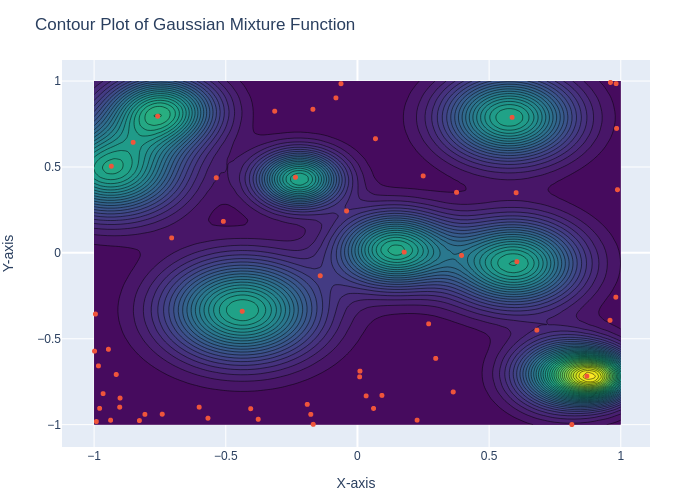

In [15]:
using PlotlyJS, Colors
# Generate the grid and evaluate the function
N = 80  # resolution of the grid
x = range(-scale_factor, scale_factor, length=N)
y = range(-scale_factor, scale_factor, length=N)
z = [f([xi, yi]) for yi in y, xi in x]

#Scatter plot the critical points of the approximant
scatter_traces = [scatter(x=df.x, y=df.y, mode="markers", marker_size=5, name="Critical Points")]

# Create the contour plot
cp = contour(x=x, y=y, z=z, ncontours=40, colorscale="Viridis", showscale=false)

# Combine contour plot and scatter traces
all_traces = [cp; scatter_traces...]

# Customize layout to handle legend groups
layout = Layout(
    title="Contour Plot of Gaussian Mixture Function",
    xaxis_title="X-axis",
    yaxis_title="Y-axis",
    legend=(tracegroupgap=10, groupclick="toggleitem"),
    height=800 # Increase the height to make room for the legend 
)

# Display the combined plot with legend
display(plot(all_traces, layout))



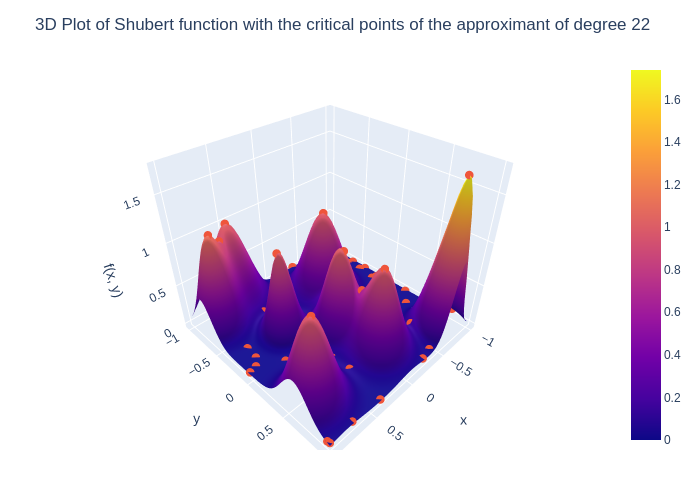

In [16]:
sf = surface(x=x, y=y, z=z)
# Had to switch the coordinates of the critical points to match the surface plot for some reason. 
crit_pts = scatter3d(x=df.y, y=df.x, z=df.z, mode="markers", marker_size=5, name="Critical Points")

# Layout for the plot
layout = Layout(title="3D Plot of Shubert function with the critical points of the approximant of degree 22",
    scene=attr(
        xaxis_title="x",
        yaxis_title="y",
        zaxis_title="f(x, y)"),
    height=800
)
# Display the plot layout,
plt = plot([sf, crit_pts], layout)

In [9]:
savefig(plt, "../data/figures/random_gaussian_function_plot.html")

"../data/figures/random_gaussian_function_plot.html"

Should plot the polynomial approximant too.